# 7.2.1 Representation of quantum information -  Square wells and qubits

Reference: Nielsen and Chuang, Page 280, Box 7.1: Square wells and qubits

## Setup

In [39]:
!pip install -q qutip

In [40]:
import numpy as np
import qutip as qt
import matplotlib.pyplot as plt

We create a numerical model of the unperturbed particle-in-a-box Hamiltonian, $H_0​=p^2/2m$

In [41]:
# System parameters
N = 200      # Number of grid points
L = 1.0      # Box length
m = 1.0      # Mass
hbar = 1.0
dx = L / (N + 1) # Grid spacing
x_vec = np.linspace(dx, L - dx, N) # Internal grid points

In [42]:
# Create the Kinetic Hamiltonian

D2 = (np.diag(np.ones(N - 1), -1) - 2 * np.diag(np.ones(N)) +
      np.diag(np.ones(N - 1), 1)) / dx**2
H0 = - (hbar**2 / (2 * m)) * D2
H0 = qt.Qobj(H0)

In [43]:
# Find the first 5 eigenstates and eigenvalues
k = 5
evals, estates = H0.eigenstates(sparse=True, eigvals=k)

In [44]:
# Define the qubit states and projectors
psi1 = estates[0] # Qubit |0>
psi2 = estates[1] # Qubit |1>
psi3 = estates[2] # First "leakage" state
psi4 = estates[3]
psi5 = estates[4]

In [45]:
# Print energy levels to confirm
print("First 5 Energy Levels:")
analytic_evals = [(n**2 * np.pi**2 * hbar**2) / (2 * m * L**2) for n in range(1, k + 1)]
for i in range(k):
    print(f"  E_{i+1}: Found={evals[i]:.4f}, Analytic={analytic_evals[i]:.4f}")

First 5 Energy Levels:
  E_1: Found=4.9347, Analytic=4.9348
  E_2: Found=19.7376, Analytic=19.7392
  E_3: Found=44.4051, Analytic=44.4132
  E_4: Found=78.9311, Analytic=78.9568
  E_5: Found=123.3073, Analytic=123.3701


In [46]:
# Define projectors to measure population in each state
P1_proj = qt.ket2dm(psi1)
P2_proj = qt.ket2dm(psi2)
P3_proj = qt.ket2dm(psi3)
P4_proj = qt.ket2dm(psi4)
P5_proj = qt.ket2dm(psi5)

In [47]:
# List of expectation-value operators
e_ops_leakage = [P1_proj, P2_proj, P3_proj, P4_proj, P5_proj]

## Simulation 1: Control Operation and State Leakage

This simulates the particle in a box in a larger Hilbert space (using its first 5 energy levels) and apply the perturbation $\delta V(x)$. This will show how a control pulse attempts to perform an operation but also causes leakage to non-qubit states (the interference of other energy states).

Ee perform operations by adding a time-dependent perturbation, $\delta V(x,t)=V_0​(t)⋅\delta V(x)$. The Spatial part is given by:

$$
\delta V(x) = −\frac{9\pi^2}{16L^2}\left(x-\frac{L}{2}\right)
$$

To perform a qubit operation (a rotation from $∣\psi_1​\rangle$ to $∣\psi_2​\rangle$), we must drive the system at a frequency $\omega_d$​ equal to the qubit energy splitting: $\omega_d​=E_2​ − E_1$​.

In [48]:
# Define the perturbation operator (spatial part)
C = (9 * np.pi**2) / (16 * L**2) # The constant C
x_op = qt.qdiags(x_vec, 0)      # Position operator on the grid
I_op = qt.qeye(N)              # Identity operator
V_pert_op = -C * (x_op - (L/2) * I_op)**2

In [49]:
# Define the drive Hamiltonian
H0_full = H0

omega_drive = evals[1] - evals[0]
print(f"Qubit Freq (E2-E1)/hbar: {omega_drive:.4f}")

drive_amplitude = 1.5

Qubit Freq (E2-E1)/hbar: 14.8029


In [50]:
def H1_coeff(t, args):
    return drive_amplitude * np.cos(omega_drive * t)

In [51]:
# Full time-dependent Hamiltonian
H_drive = [H0_full, [V_pert_op, H1_coeff]]

# Initial state: Qubit |0> (i.e., psi_1)
psi_initial = psi1

# Simulation time
t_list = np.linspace(0, 5.0, 400)

In [52]:
result_leakage = qt.sesolve(H_drive, psi_initial, t_list, e_ops=e_ops_leakage)

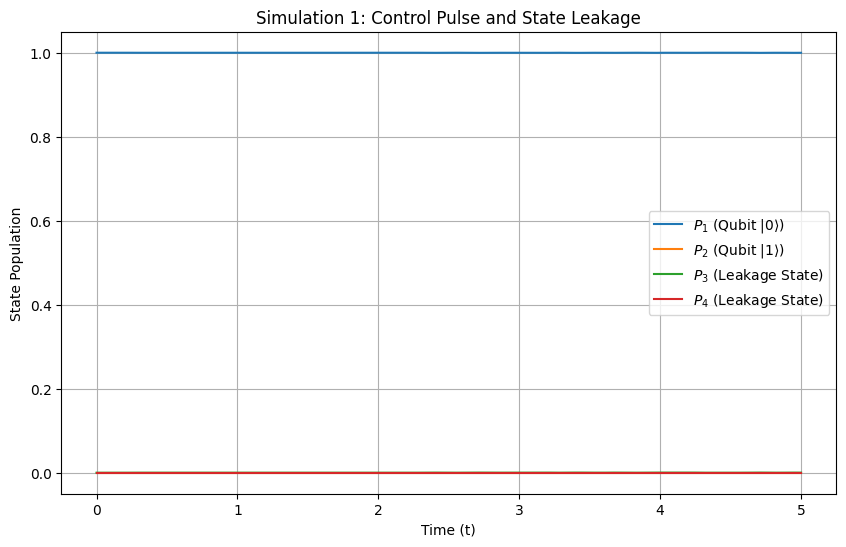

In [53]:
plt.figure(figsize=(10, 6))
plt.plot(result_leakage.times, result_leakage.expect[0], label=r'$P_1$ (Qubit $|0\rangle$)')
plt.plot(result_leakage.times, result_leakage.expect[1], label=r'$P_2$ (Qubit $|1\rangle$)')
plt.plot(result_leakage.times, result_leakage.expect[2], label=r'$P_3$ (Leakage State)')
plt.plot(result_leakage.times, result_leakage.expect[3], label=r'$P_4$ (Leakage State)')
plt.title("Simulation 1: Control Pulse and State Leakage")
plt.xlabel("Time (t)")
plt.ylabel("State Population")
plt.legend()
plt.grid(True)
plt.show()

The plot obtained is in accordance with the pertubation mentioned in the textbook, but ideally it should not be flat. This highlights a contradiction between the textbook's equation and its claim. This is because:
1. The Perturbation $\delta V(x)∝(x−L/2)^2$. This is a symmetric function.
2. The Qubit States:

    $∣\psi_1\rangle$ (ground state) is symmetric.

    $∣\psi_2​\rangle$ (first excited state) is anti-symmetric.
3. To drive a transition from $∣\psi_1​\rangle -> ∣\psi_2​\rangle$, the matrix element $\langle\psi_1​∣\delta V(x)∣\psi_2​\rangle$ must be non-zero. However, the integral of a (Symmetric × Symmetric × Anti-symmetric) function is exactly zero.

Therefore, the perturbation $\delta V(x)$ cannot drive the $∣\psi_1​\rangle <-> ∣\psi_2​\rangle$ transition. We were driving at that frequency, but the "antenna" (the perturbation) has zero-coupling. This is why the plot correctly shows no change.

To properly simulate leakage, we should drive the system at the $∣\psi_1​\rangle -> ∣\psi_3​\rangle$ transition frequency.

In [54]:
# Correction
omega_drive = evals[2] - evals[0]

print(f"Qubit Freq (E2-E1)/hbar: {omega_drive:.4f}")
drive_amplitude = 1.5

Qubit Freq (E2-E1)/hbar: 39.4704


In [55]:
def H1_coeff(t, args):
    return drive_amplitude * np.cos(omega_drive * t)

In [56]:
# Full time-dependent Hamiltonian
H_drive = [H0_full, [V_pert_op, H1_coeff]]

# Initial state: Qubit |0> (i.e., psi_1)
psi_initial = psi1

# Simulation time
t_list = np.linspace(0, 5.0, 400)

In [57]:
result_leakage = qt.sesolve(H_drive, psi_initial, t_list, e_ops=e_ops_leakage)

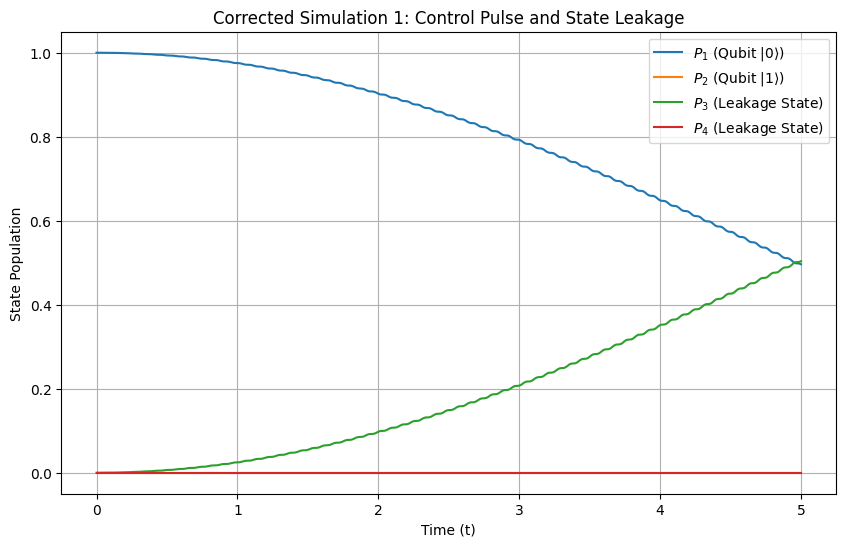

In [58]:
plt.figure(figsize=(10, 6))
plt.plot(result_leakage.times, result_leakage.expect[0], label=r'$P_1$ (Qubit $|0\rangle$)')
plt.plot(result_leakage.times, result_leakage.expect[1], label=r'$P_2$ (Qubit $|1\rangle$)')
plt.plot(result_leakage.times, result_leakage.expect[2], label=r'$P_3$ (Leakage State)')
plt.plot(result_leakage.times, result_leakage.expect[3], label=r'$P_4$ (Leakage State)')
plt.title("Corrected Simulation 1: Control Pulse and State Leakage")
plt.xlabel("Time (t)")
plt.ylabel("State Population")
plt.legend()
plt.grid(True)
plt.show()

Interpretation:
- $|\psi_1 \rangle$ (ie, Qubit $∣0\rangle$, the ground state) is symmetric around the center of the box
- $|\psi_2 \rangle$ (ie, Qubit $∣1\rangle$, the first excited state) is anti-symmetric around center of the box
- The perturbation $\delta V(x)$ is also symmetric around the center of the box,

To drive a transition from state $|\psi_1 \rangle$ to state $|\psi_2 \rangle$, the matrix element $\langle \psi_1∣\delta V(x)∣\psi_2\rangle$ must be non-zero. Since the integrand is anti-symmetric, the integral over a symmetric domain is 0.

Hence, the orange line, which represents the time evolution of $|\psi_2\rangle$ is a flat line. Hence, the transition happens into the leakage state $|\psi_3\rangle$

## Simulation 2: Control Operation and State Leakage with an anti-symmetric pertubation

In [64]:
# Define an ANTI-SYMMETRIC perturbation: dV(x) ~ (x - L/2)
V_pert_op = (x_op - (L/2) * I_op)

In [65]:
# Drive frequency: resonant with the qubit transition
omega_drive = evals[1] - evals[0]
print(f"Driving at Qubit Freq (E2-E1)/hbar: {omega_drive:.4f}")

Driving at Qubit Freq (E2-E1)/hbar: 14.8029


In [72]:
drive_amplitude = 2.0

In [73]:
# Time-dependent coefficient for H1
def H1_coeff(t, args):
    return drive_amplitude * np.cos(omega_drive * t)

In [74]:
# Full time-dependent Hamiltonian
H_drive = [H0, [V_pert_op, H1_coeff]]

# Initial state: Qubit |0> (i.e., psi_1)
psi_initial = psi1

# Simulation time
t_list = np.linspace(0, 5.0, 400)

In [75]:
result_good = qt.sesolve(H_drive, psi_initial, t_list, e_ops=e_ops_leakage)

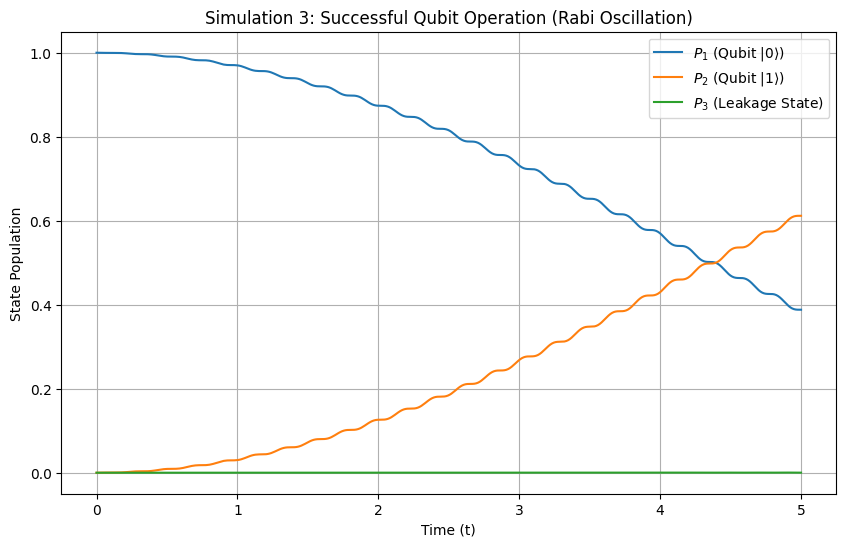

In [76]:
plt.figure(figsize=(10, 6))
plt.plot(result_good.times, result_good.expect[0], label=r'$P_1$ (Qubit $|0\rangle$)')
plt.plot(result_good.times, result_good.expect[1], label=r'$P_2$ (Qubit $|1\rangle$)')
plt.plot(result_good.times, result_good.expect[2], label=r'$P_3$ (Leakage State)')
plt.title("Simulation 3: Successful Qubit Operation (Rabi Oscillation)")
plt.xlabel("Time (t)")
plt.ylabel("State Population")
plt.legend()
plt.grid(True)
plt.show()

Web observe perfect Rabi oscillations. The population flows entirely from state 1 to state 2 and back again. The green line remains flat at zero, because that transition is now 0 due to the integrand being anti-symmetric. By choosing our control pulse to be anti-symmetric, we have successfully driven the $P_1$ to $P_2$​ transition and, at the same time, prevented leakage to the $P_3$​ state.

## Simulation 3: Environmental Decoherence (T2​ Dephasing)

Here, we use an idealized two-level qubit system and show how coupling it to an external control system (that is, an environment) causes a different kind of decoherence: dephasing ($T_2$​ decay) which destroys superposition states.

For this, we will use an ideal 2-level qubit. We ignore the leakage problem from Simulation 1. We want to see what happens to a superposition state, as the text says decoherence destroy(s) qubit superposition states. The minimum lifetime for this is $T_2$​.

We will model this using the master equation. We will add a collapse operator ($c_{op}$​) that models the environment "measuring" the qubit's state, which causes dephasing. A $\sigma_z$​ collapse operator is a standard model for pure $T_2$​ dephasing.

- **Hamiltonian:** $H = \frac{\omega_q​}{2}​\sigma_z$​ (a qubit with energy splitting $\omega_q$​)
- **Initial State:** $∣\psi(0)\rangle = \frac{1}{\sqrt{2}}​(∣0\rangle+∣1\rangle)$ (a pure superposition state)
- **Collapse Operator:** $c_{op} ​= \sqrt{\gamma}⋅\sigma_z$​ (where $\gamma$ is the dephasing rate)

In [59]:
# Qubit energy splitting
omega_qubit = evals[1] - evals[0]

# Ideal 2-level Hamiltonian
H_ideal = 0.5 * omega_qubit * qt.sigmaz()

# Initial state: a superposition |+> = (|0> + |1>)/sqrt(2)
psi0_ideal = (qt.basis(2, 0) + qt.basis(2, 1)).unit()

# Define the dephasing rate (gamma)
dephasing_rate = omega_qubit * 0.2

# Define the collapse operator for T2 dephasing
c_op_dephasing = np.sqrt(dephasing_rate) * qt.sigmaz()

# Simulation time
t_list_decay = np.linspace(0, 5.0 / dephasing_rate, 200)

In [60]:
# simulation with decoherence
result_decay = qt.mesolve(H_ideal, psi0_ideal, t_list_decay,
                          c_ops=[c_op_dephasing],
                          e_ops=[qt.sigmax(), qt.sigmay(), qt.sigmaz()])

In [61]:
# simulation without decoherence
result_ideal = qt.mesolve(H_ideal, psi0_ideal, t_list_decay,
                          c_ops=[],
                          e_ops=[qt.sigmax(), qt.sigmay(), qt.sigmaz()])

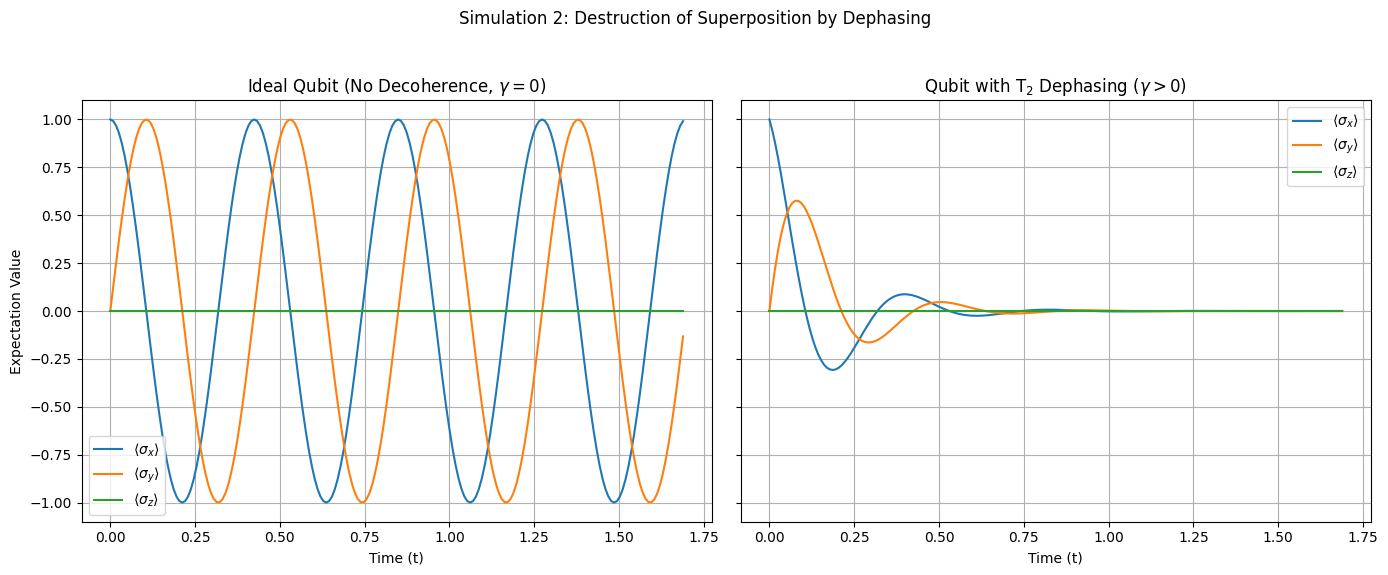

In [62]:
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(14, 6), sharey=True)

# Plot 1: Ideal, No Decoherence
ax1.plot(result_ideal.times, result_ideal.expect[0], label=r'$\langle \sigma_x \rangle$')
ax1.plot(result_ideal.times, result_ideal.expect[1], label=r'$\langle \sigma_y \rangle$')
ax1.plot(result_ideal.times, result_ideal.expect[2], label=r'$\langle \sigma_z \rangle$')
ax1.set_title(r"Ideal Qubit (No Decoherence, $\gamma=0$)")
ax1.set_xlabel("Time (t)")
ax1.set_ylabel("Expectation Value")
ax1.legend()
ax1.grid(True)

# Plot 2: With Decoherence
ax2.plot(result_decay.times, result_decay.expect[0], label=r'$\langle \sigma_x \rangle$')
ax2.plot(result_decay.times, result_decay.expect[1], label=r'$\langle \sigma_y \rangle$')
ax2.plot(result_decay.times, result_decay.expect[2], label=r'$\langle \sigma_z \rangle$')
ax2.set_title(rf"Qubit with T$_2$ Dephasing ($\gamma > 0$)")
ax2.set_xlabel("Time (t)")
ax2.legend()
ax2.grid(True)

plt.suptitle("Simulation 2: Destruction of Superposition by Dephasing")
plt.tight_layout(rect=[0, 0.03, 1, 0.95])
plt.show()

We tracked the expectation values of $\langle \sigma_x \rangle$, $\langle \sigma_y \rangle$, and $\langle \sigma_z \rangle$. For our initial state, $\langle \sigma_x \rangle$=1 and $\langle \sigma_y \rangle$=$\langle \sigma_z \rangle = 0$ . Decoherence caused $\langle \sigma_x \rangle$ and $\langle \sigma_y \rangle$ to decay to 0, as predicted.

1. **Ideal Qubit:** Without decoherence ($\gamma=0$), the qubit precesses. The $\langle \sigma_x \rangle$ and $\langle \sigma_y \rangle$ components oscillate, meaning the qubit stays in a pure superposition state, just rotating around the z-axis.
2. **Qubit with Dephasing:** With decoherence $(\gamma>0)$, the $\langle \sigma_x \rangle$ and $\langle \sigma_y \rangle$ components exponentially decay to zero. The final state is no longer a pure superposition. It has become a mixed state, represented by the Bloch vector pointing to $(0, 0, 0)$